# Bank Customer Churn -  CATboost 


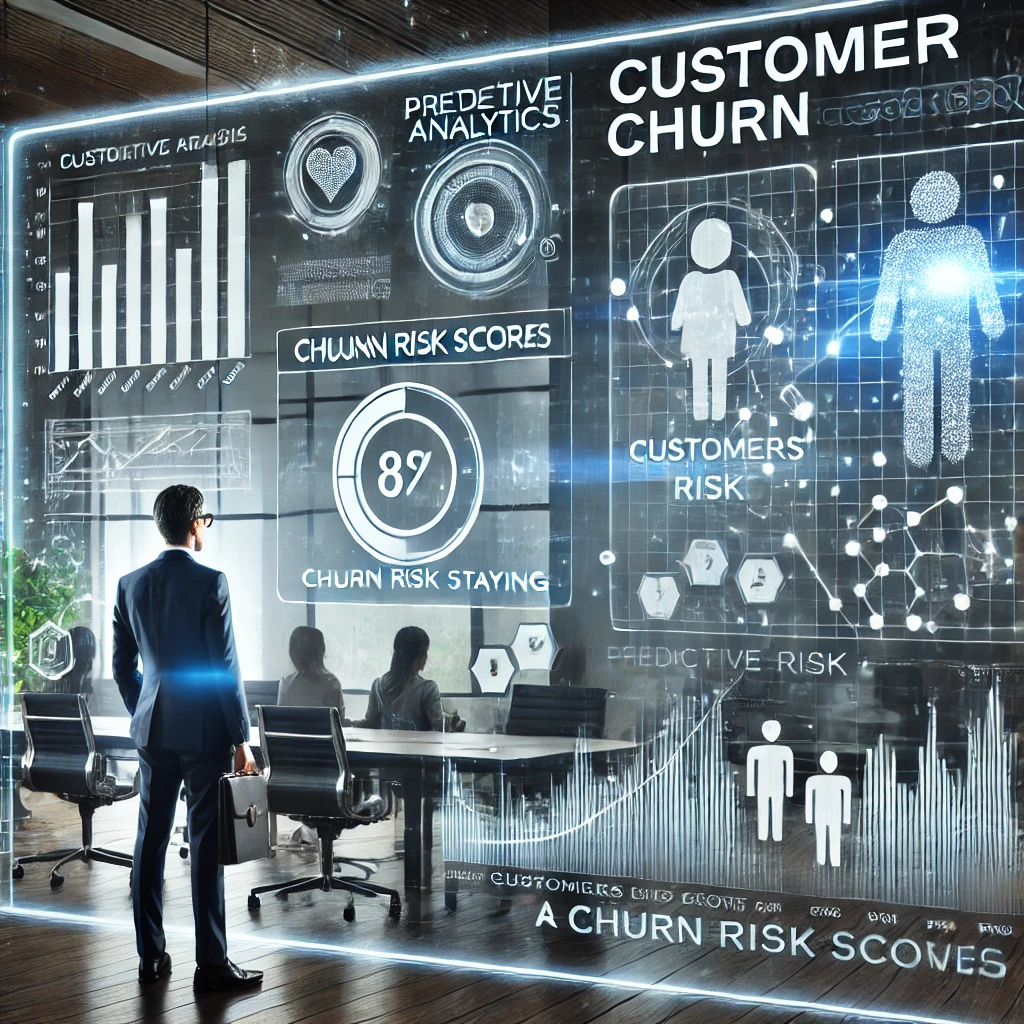

# Importando Bibliotecas 


In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
import logging
import optuna
from catboost import CatBoostClassifier, Pool
import torch
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.cm as cm
import catboost


from sklearn.preprocessing import StandardScaler #, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score,
    roc_curve, confusion_matrix, auc
)

from optuna.samplers import TPESampler
import pickle

########################### para KAGGLE ################################################################################################################
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
########################################################################################################################################################


# Dicinário de Dados 


| **Variável**         | **Tipo**   | **Descrição**                                                                                                                                     |
|-----------------------|------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| RowNumber            | int64      | Número do registro (linhas), sem efeito na construção de modelos.                                                                                |
| CustomerId           | int64      | ID do cliente, sem efeito sobre o estudo.                                                                                                       |
| Surname              | object     | Sobrenome do cliente, sem impacto na análise.                                                                                                   |
| CreditScore          | int64      | Pontuação de crédito, pode indicar tendência de permanência de clientes com pontuação alta.                                                     |
| Geography            | object     | Localização do cliente, pode influenciar a decisão de evasão.                                                                                   |
| Gender               | object     | Gênero do cliente, possível influência na evasão.                                                                                               |
| Age                  | int64      | Idade do cliente, clientes mais velhos tendem a permanecer.                                                                                     |
| Tenure               | int64      | Anos que o cliente está no banco, clientes novos têm maior chance de evasão.                                                                    |
| Balance              | float64    | Saldo na conta, pessoas com saldos altos são menos propensas a sair.                                                                            |
| NumOfProducts        | int64      | Número de produtos adquiridos pelo cliente.                                                                                                    |
| HasCrCard            | int64      | Indica se o cliente tem cartão de crédito, clientes com cartão são menos propensos à evasão.                                                    |
| IsActiveMember       | int64      | Clientes ativos têm menor chance de evasão.                                                                                                    |
| EstimatedSalary      | float64    | Salário estimado, clientes com salários mais altos tendem a permanecer.                                                                         |
| Exited               | int64      | Indica se o cliente saiu ou não do banco, variável de predição (“churn”).                                                                       |
| Complain             | int64      | Indica se o cliente fez reclamação.                                                                                                             |
| Satisfaction Score   | int64      | Pontuação de satisfação com a resolução de reclamação.                                                                                          |
| Card Type            | object     | Tipo de cartão que o cliente possui.                                                                                                            |
| Points Earned        | int64      | Pontos ganhos pelo cliente.                                                                                                                     |


# Análise Exploratória (EDA) & Data Wrangling 


In [34]:

# base_original = pd.read_csv('/kaggle/input/Customer-Churn-Records.csv', sep=',') #KAGGLE
base_original = pd.read_csv('C:/Users/jgeov/iCloudDrive/Treinamento/Treinamento Data Science/Projetos/Customer-Churn-Records.csv',sep=',') #LOCAL

#configs para nao quebrar linhas no print do  df
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.max_columns', None)

#primeiras linhas 
base_original.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  Complain  Satisfaction Score Card Type  Point Earned
0          1    15634602  Hargrave          619    France  Female   42       2       0.00              1          1               1        101348.88       1         1                   2   DIAMOND           464
1          2    15647311      Hill          608     Spain  Female   41       1   83807.86              1          0               1        112542.58       0         1                   3   DIAMOND           456
2          3    15619304      Onio          502    France  Female   42       8  159660.80              3          1               0        113931.57       1         1                   3   DIAMOND           377
3          4    15701354      Boni          699    France  Female   39       1       0.00              2          0               0         93826.63       0         0                   5      GOLD           350
4          5    15737888  Mitchell          850     Spain  Female   43       2  125510.82              1          1               1         79084.10       0         0                   5      GOLD           425

Analisando primeiras impressões da base de dados


In [35]:
#Dimensões 
print("Numero de linhas:", base_original.shape[0]) 
print("Numero de colunas:", base_original.shape[1])


Numero de linhas: 10000
Numero de colunas: 18


In [36]:
#tipos
base_original.dtypes

RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object

In [37]:
#checando se há valores nulos 
base_original.isnull().sum()  
#valores nulos nao encontrados 

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

In [38]:
#removidas por serem meramente identificadoras: RowNumber, CustomerId e Surname 

df = base_original[['CreditScore',
                    'Gender',
                    'Geography',
                    'Age',
                    'Tenure',
                    'Balance',
                   'NumOfProducts',
                    'HasCrCard',
                    'IsActiveMember',
                   'EstimatedSalary',
                    'Complain',
                    'Satisfaction Score',
                   'Card Type',
                    'Point Earned',
                    'Exited'
                   ]]

# Resumo estatístico 
quanti = df[['EstimatedSalary', 'Balance', 'CreditScore', 'Age', 'Tenure', 'Point Earned']]
resumo_estati_quant = quanti.describe().style.format(lambda x: f'{x:,.1f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) # Formatação com 1 casa decimal e separadores invertidos

resumo_estati_quant

* Resumo estatistico de variaveis qualitativas (frequancias)

* Os resumos estatisticos sao importantes para primeiras nocoes de desbalance, a amplitude e distribuicao de valores
minimos maximos e um breve entendimento se serao necessarios tratamentos nessas variaveis, decorrentes dessas observacoes; 

* Podemos notar que a principio as ditribuicoes nao sao absurdas e o desbalance esta pricipalemnte nas variavies Complain e Exited (variavel alvo do estudo, a chamaremos de churn) indicando que sera necessario tratar isso;

* Franca tem mais observacoes que os demais paises; 

* A maioria dos clientes tem cartao de credito; 

* A maioria dos clientes tem entre 1 e 2 produtos. 


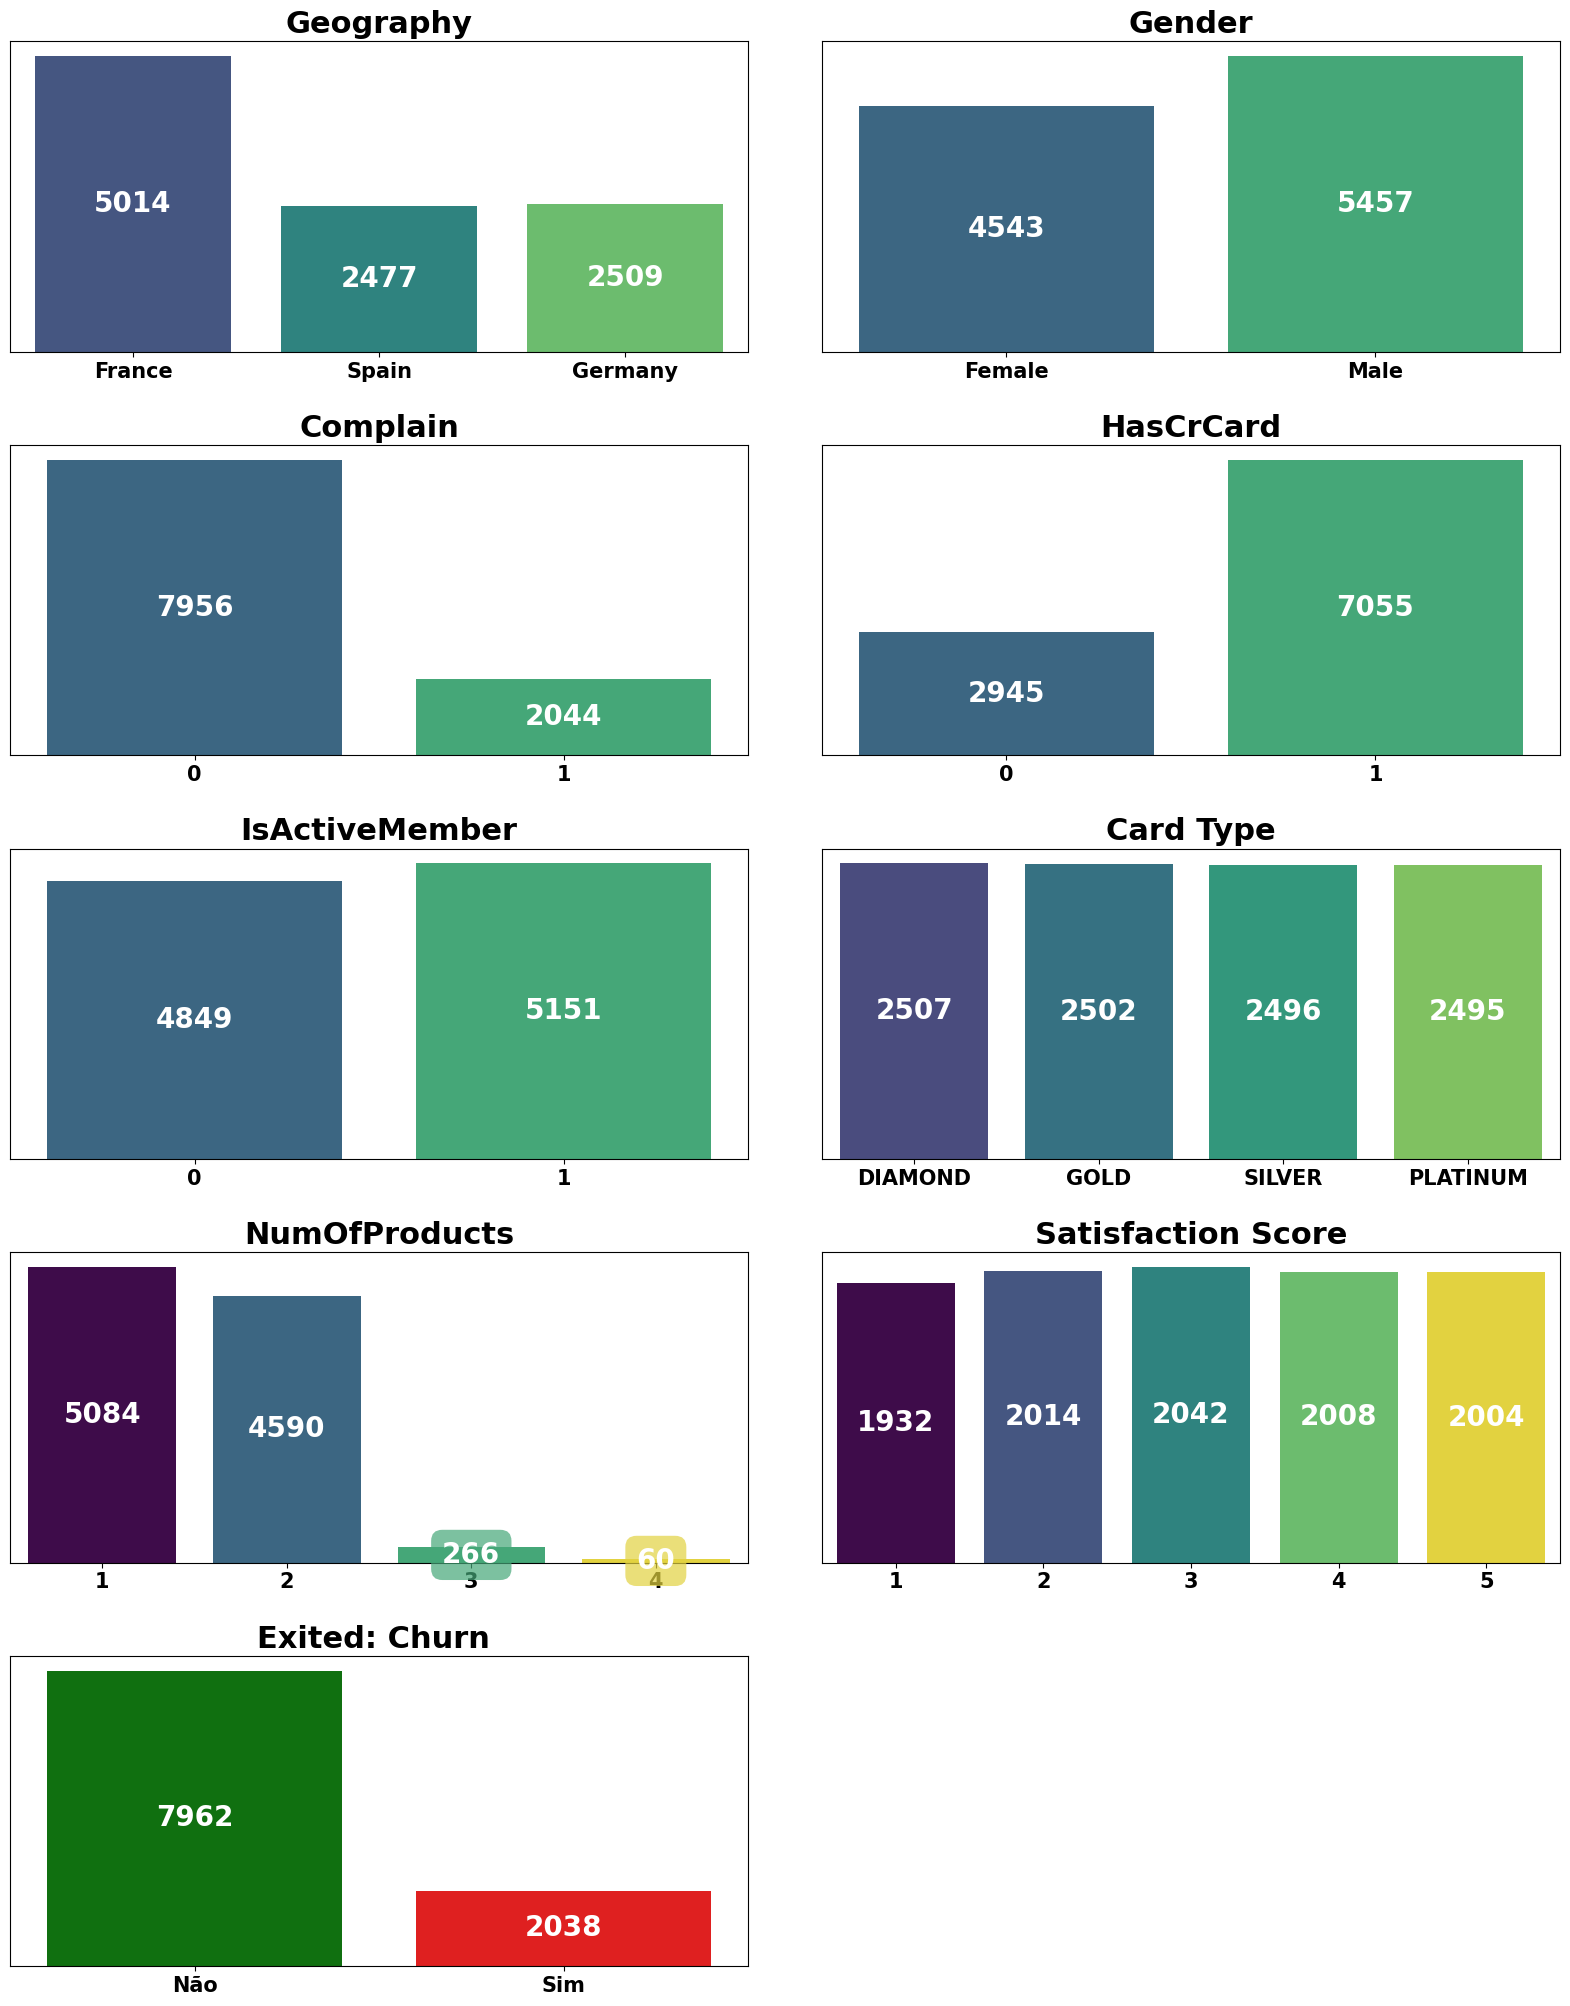

In [39]:
#Resumo estatistico 

#separando quali's para analise 
quali = df[['HasCrCard', 'IsActiveMember', 'Geography','Gender'
            ,'Complain','Exited','Card Type','NumOfProducts','Satisfaction Score']]

quali = quali.astype('object')

#quali.dtypes



def add_value_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        color = p.get_facecolor()
        ax.text(p.get_x() + p.get_width() / 2., height / 2.,
                f'{int(height)}',
                ha='center', va='center', fontsize=20, color='white', fontweight='bold',
                bbox=dict(facecolor=color, edgecolor='none', alpha=0.7,
                          boxstyle='round,pad=0.4', linewidth=1))

plt.figure(figsize=(20, 25))

# Geography
plt.subplot(5, 2, 1)
ax1 = plt.gca()
ax1.set_title('Geography', fontsize=22, fontweight='bold')
sns.countplot(x='Geography', hue='Geography', palette='viridis', data=base_original, ax=ax1, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax1)

# Gender
plt.subplot(5, 2, 2)
ax2 = plt.gca()
ax2.set_title('Gender', fontsize=22, fontweight='bold')
sns.countplot(x='Gender', hue='Gender', palette='viridis', data=base_original, ax=ax2, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax2)

# Complain
plt.subplot(5, 2, 3)
ax10 = plt.gca()
ax10.set_title('Complain', fontsize=22, fontweight='bold')
sns.countplot(x='Complain', hue='Complain', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)

# HasCrCard
plt.subplot(5, 2, 4)
ax5 = plt.gca()
ax5.set_title('HasCrCard', fontsize=22, fontweight='bold')
sns.countplot(x='HasCrCard', hue='HasCrCard', palette='viridis', data=base_original, ax=ax5, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax5)

# IsActiveMember
plt.subplot(5, 2, 5)
ax6 = plt.gca()
ax6.set_title('IsActiveMember', fontsize=22, fontweight='bold')
sns.countplot(x='IsActiveMember', hue='IsActiveMember', palette='viridis', data=base_original, ax=ax6, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax6)

# Card Type
plt.subplot(5, 2, 6)
ax10 = plt.gca()
ax10.set_title('Card Type', fontsize=22, fontweight='bold')
sns.countplot(x='Card Type', hue='Card Type', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)


# NumOfProducts
plt.subplot(5, 2, 7)
ax10 = plt.gca()
ax10.set_title('NumOfProducts', fontsize=22, fontweight='bold')
sns.countplot(x='NumOfProducts', hue='NumOfProducts', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)


# Satisfaction Score
plt.subplot(5, 2, 8)
ax11 = plt.gca()
ax11.set_title('Satisfaction Score', fontsize=22, fontweight='bold')
sns.countplot(x='Satisfaction Score', hue='Satisfaction Score', palette='viridis', data=base_original, ax=ax11, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax11)






# Exited
plt.subplot(5, 2, 9)
ax11 = plt.gca()
ax11.set_title('Exited: Churn ', fontsize=22, fontweight='bold')
custom_palette = ['green', 'red']
sns.countplot(x='Exited', hue='Exited', palette=custom_palette, data=base_original, ax=ax11, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax11)

ax11.set_xticks([0, 1])
ax11.set_xticklabels(['Não', 'Sim'], fontsize=15, fontweight='bold')

# Ajustando espaçamento
plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.show()




* Visualizando o comportmento da variavel alvo (exited) em relacao as demais variaveis; 

* Vemos claramente que existe o disbalance de classes na variavel churn, pela cor verde presente fortemente em todas variaveis, posteriormente isso sera tratado/mitigado; 

* Ja e possivel notar um forte indicio de alta correlacao entre churn e complain, posteriormente isso sera testado. 



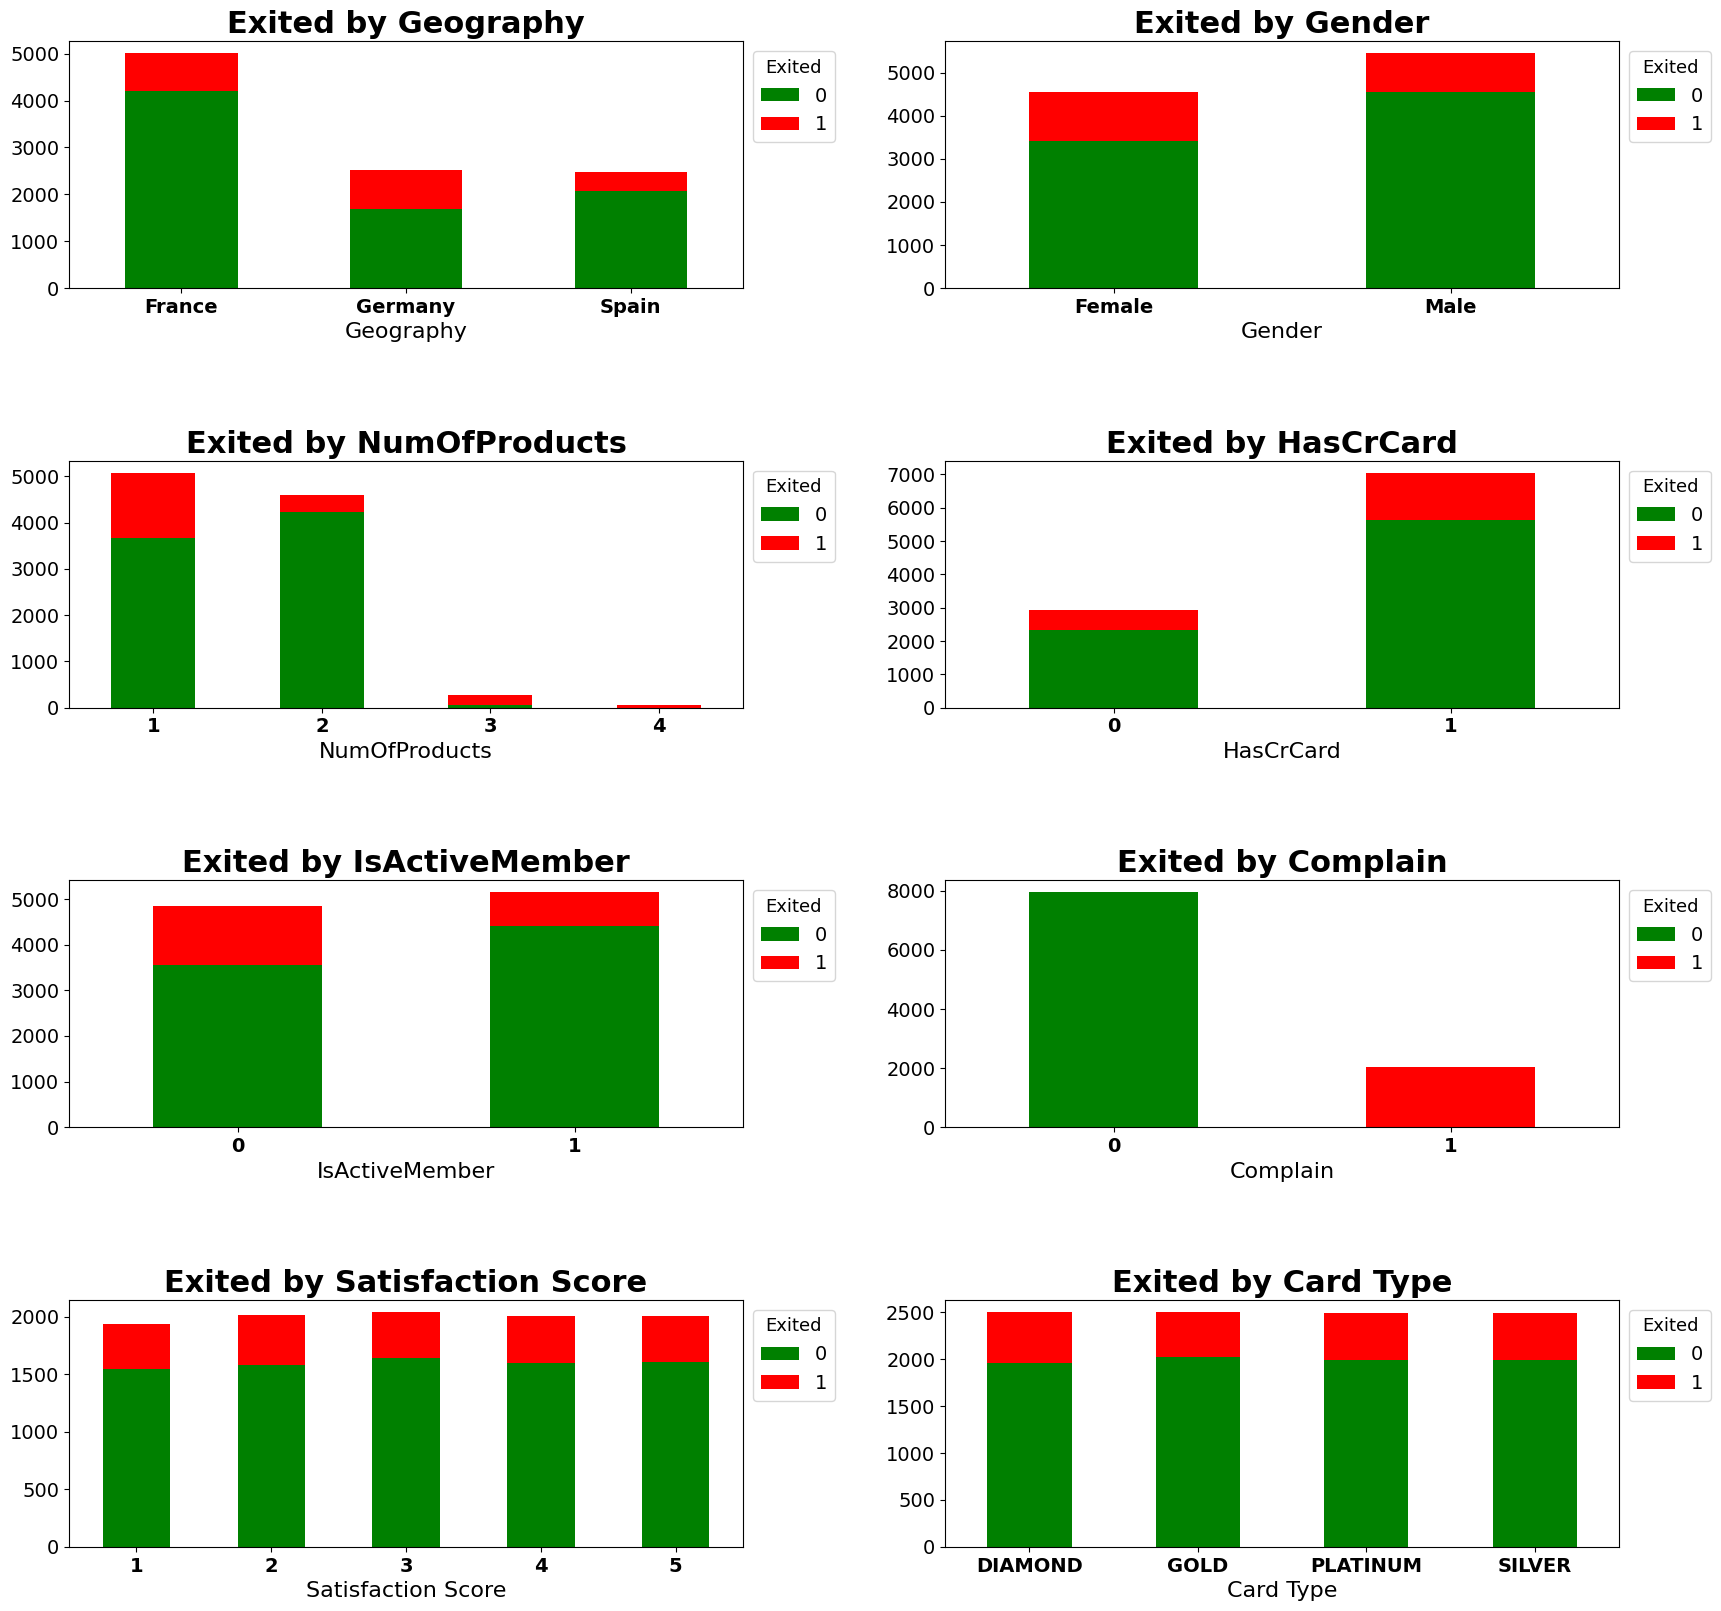

In [40]:
#%% Variável alvo em relação as demais variáveis 





plt.figure(figsize=(20, 25)) #tamanho do painel grafico

#funcao de adicao de legenda no canto superior direito e garante rotulos 
def add_legend(ax):
    
    handles, labels = ax.get_legend_handles_labels()
    if not handles:
        
        # Se não houver handles, forca a adicao
        handles = [plt.Rectangle((0,0),1,1, color=c) for c in ['green', 'red']]
        labels = ['Not Exited', 'Exited']
        
    # Adiciona a legenda fora da área das barras
    ax.legend(handles, labels, loc='upper left', fontsize=14, title='Exited', title_fontsize='13',  
              bbox_to_anchor=(1.0, 1)) 




# Geography
plt.subplot(5, 2, 1)
counts = base_original.groupby(['Geography', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Geography', fontsize=22, fontweight='bold')
plt.xlabel('Geography', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Gender
plt.subplot(5, 2, 2)
counts = base_original.groupby(['Gender', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca()) 
plt.title('Exited by Gender', fontsize=22, fontweight='bold')
plt.xlabel('Gender', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# NumOfProducts
plt.subplot(5, 2, 3)
counts = base_original.groupby(['NumOfProducts', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by NumOfProducts', fontsize=22, fontweight='bold')
plt.xlabel('NumOfProducts', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# HasCrCard
plt.subplot(5, 2, 4)
counts = base_original.groupby(['HasCrCard', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by HasCrCard', fontsize=22, fontweight='bold')
plt.xlabel('HasCrCard', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# IsActiveMember
plt.subplot(5, 2, 5)
counts = base_original.groupby(['IsActiveMember', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca()) 
plt.title('Exited by IsActiveMember', fontsize=22, fontweight='bold')
plt.xlabel('IsActiveMember', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Complain
plt.subplot(5, 2, 6)
counts = base_original.groupby(['Complain', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Complain', fontsize=22, fontweight='bold')
plt.xlabel('Complain', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Satisfaction Score
plt.subplot(5, 2, 7)
counts = base_original.groupby(['Satisfaction Score', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Satisfaction Score', fontsize=22, fontweight='bold')
plt.xlabel('Satisfaction Score', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Card Type
plt.subplot(5, 2, 8)
counts = base_original.groupby(['Card Type', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Card Type', fontsize=22, fontweight='bold')
plt.xlabel('Card Type', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Ajusta a distância entre os gráficos
plt.subplots_adjust(hspace=0.7, wspace=0.3)

# Variaveis Dummies

* A maioria dos modelos necessita de transformar as variaveis categoricas em numericas, e o modelo MLP (Multilayer Perceptron) e um deles; 

* A transformacao de categoricas em numericas precisa ser feita com processos adequados para nao cometer ponderacao arbitrária no desenvolvimento. 

* foi aplicado one-hot encoding para isso. Esse processo e chamado de "Dummizacao". 
 

In [41]:
# Dumizando

# Suprime todos os warnings de futuro (deixa mais clean) 
warnings.filterwarnings('ignore', category=FutureWarning)



# Lista de variaveis a serem transformadas
cols_to_transform = ['HasCrCard', 'IsActiveMember', 'Geography', 'Gender', 'Card Type']

# Convertendo para string
df.loc[:, cols_to_transform] = df.loc[:, cols_to_transform].astype(str)

# one-hot encoding 
df_dummies = pd.get_dummies(df, columns=cols_to_transform, dtype=int, drop_first=False)



# variável alvo 'Exited' para o tipo numérico, pois o modelo requer isso de todas as varaiveis (por isso dumizar)
df_dummies['Exited'] = df_dummies['Exited'].astype('int64')

print(df_dummies.dtypes)

CreditScore             int64
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
EstimatedSalary       float64
Complain                int64
Satisfaction Score      int64
Point Earned            int64
Exited                  int64
HasCrCard_0             int32
HasCrCard_1             int32
IsActiveMember_0        int32
IsActiveMember_1        int32
Geography_France        int32
Geography_Germany       int32
Geography_Spain         int32
Gender_Female           int32
Gender_Male             int32
Card Type_DIAMOND       int32
Card Type_GOLD          int32
Card Type_PLATINUM      int32
Card Type_SILVER        int32
dtype: object


# Separação Treino e Teste & Adicao de Features quadráticas

* A separacao em treino e teste alem de uma boa pratica e extreamente necessario na construcao de modelos de machine learning; 

* Tambem foram adicionadas variaveis quadraticas, ou seja, com operacao matematica aplicadas em variaveis originais gerando novas variaveis. Isso foi feito para capturar algum tipo de comportamento nao linear; 

* Foi considerado aplicar transformacao polinomial nas variaveis, por isso foi primeiro aplicado o termo quadratico, que nao apresentou melhoria significativa a ponto de aplicarmos polinomias; 

* Alem disso MLPs capturam naturalmente comportamentos nao lineares. O termo quadratico foi util para validacao durante o estudo mas a melhoria foi baixa, por isso mantemos apenas os termos quadraticos sem incluir interacoes entre variaveis (seria aplicacao Polinomias completo); 



* Tambem e possivel notar o desbalanceamento das classes  nas bases tanto em treino quanto em teste no grafico final; 

* Tambem garantimos a mesma proporcao (80/20) tanto em treino quanto em teste na separacao das bases , ou seja, equidade de divisao de dados e equilibrio. 


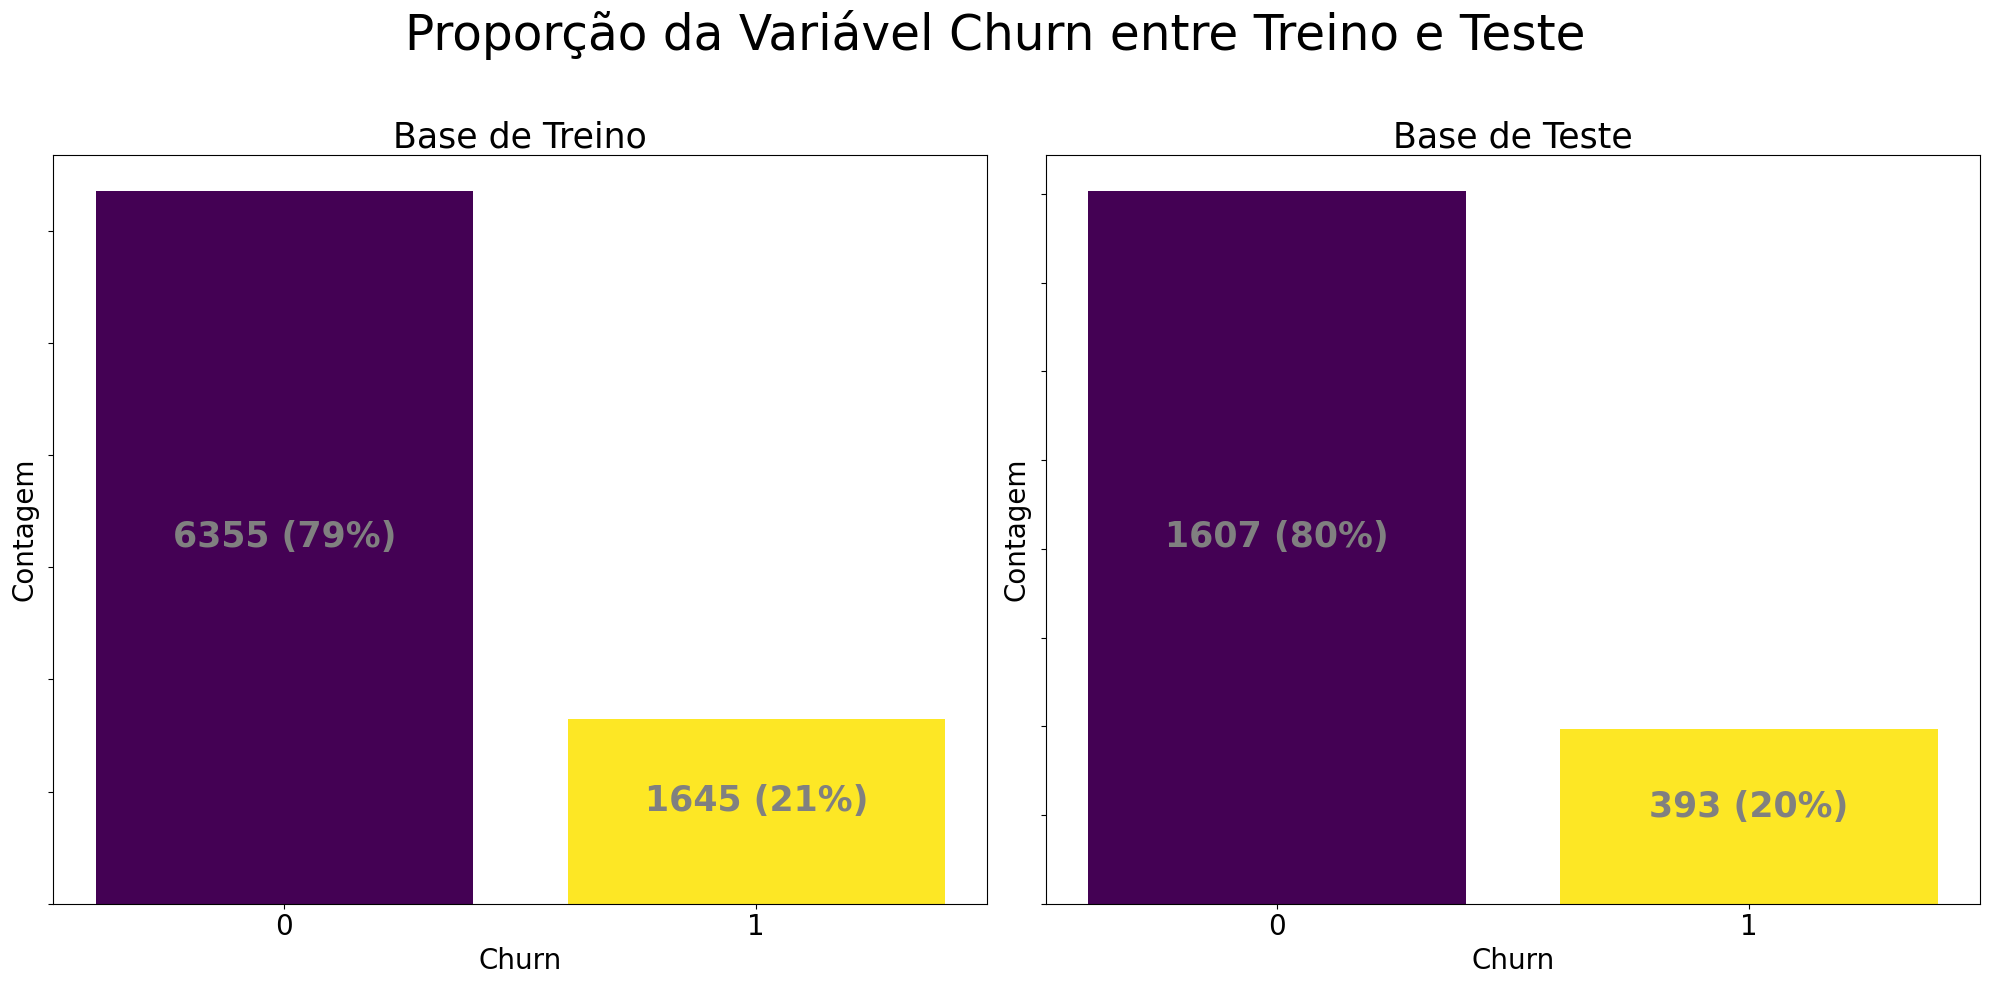

In [42]:
#X ---> Variáveis explicativas 
#Y ---> Evento de estudo (variável TARGET, evento de estudo, ^y etc..)

df_dummies = df_dummies.drop(columns=['Complain']) #correlacao altissima com a variavel alvo


X = df_dummies .drop('Exited', axis=1)

# VARIAVEIS QUADRATICAS 
X['Balance_Squared'] = X['Balance'] ** 2
X['Age_Squared'] = X['Age'] ** 2
X['CreditScore_Squared'] = X['CreditScore'] ** 2
X['NumOfProducts_Squared'] = X['NumOfProducts'] ** 2
X['Tenure_Squared'] = X['Tenure'] ** 2
X['EstimatedSalary_Squared'] = X['EstimatedSalary'] ** 2



y =  df_dummies['Exited']


#separando em treino e teste 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Visualizando a proporção de eventos de churn (TARGET) nas bases de TREINO e TESTE 

# Contando os valores 
churn_counts_train = y_train.value_counts()
churn_counts_test = y_test.value_counts()


# plot que contem os graficos
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Proporção da Variável Churn entre Treino e Teste', fontsize=35)  
cmap = plt.get_cmap('viridis', 2) #paleta de cores



# Gráfico da base de treino
bars_train = axs[0].bar(churn_counts_train.index, churn_counts_train.values, color=cmap(range(2)))
axs[0].set_title('Base de Treino', fontsize=25)
axs[0].set_xlabel('Churn', fontsize=20)
axs[0].set_ylabel('Contagem', fontsize=20)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['0', '1'], fontsize=20)
axs[0].set_yticklabels([]) # Ocultando os valores do eixo y

# Adicionando rótulos de dados
total_train = churn_counts_train.sum()
for bar in bars_train:
    count = int(bar.get_height())
    percentage = round(count / total_train * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  #valor absoluto e o percentual
    axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')




# Gráfico da base de teste
bars_test = axs[1].bar(churn_counts_test.index, churn_counts_test.values, color=cmap(range(2)))
axs[1].set_title('Base de Teste', fontsize=25)
axs[1].set_xlabel('Churn', fontsize=20)
axs[1].set_ylabel('Contagem', fontsize=20)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['0', '1'], fontsize=20)
axs[1].set_yticklabels([])# Ocultando os valores do eixo y

# Adicionando rótulos de dados
total_test = churn_counts_test.sum()
for bar in bars_test:
    count = int(bar.get_height())
    percentage = round(count / total_test * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  #valor absoluto e o percentual
    axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')



# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.95])  # forca espaco para o titulo
plt.show()




# Verificando correlacoes depois de construcao total de features e Dummizacao 

* Verificar as correlacoes e extreammente importante, elas podem indicar a famosa multicolinearidade, que atrapalha a maioria dos modelos; 

* no caso da MLP (pelo menos a presente aplicacao) ela nao afetou, a observei com atencao, mas nao impactou. Decidi manter as variveis mesmo com multicolinearidade em algumas (nao se assuste). 



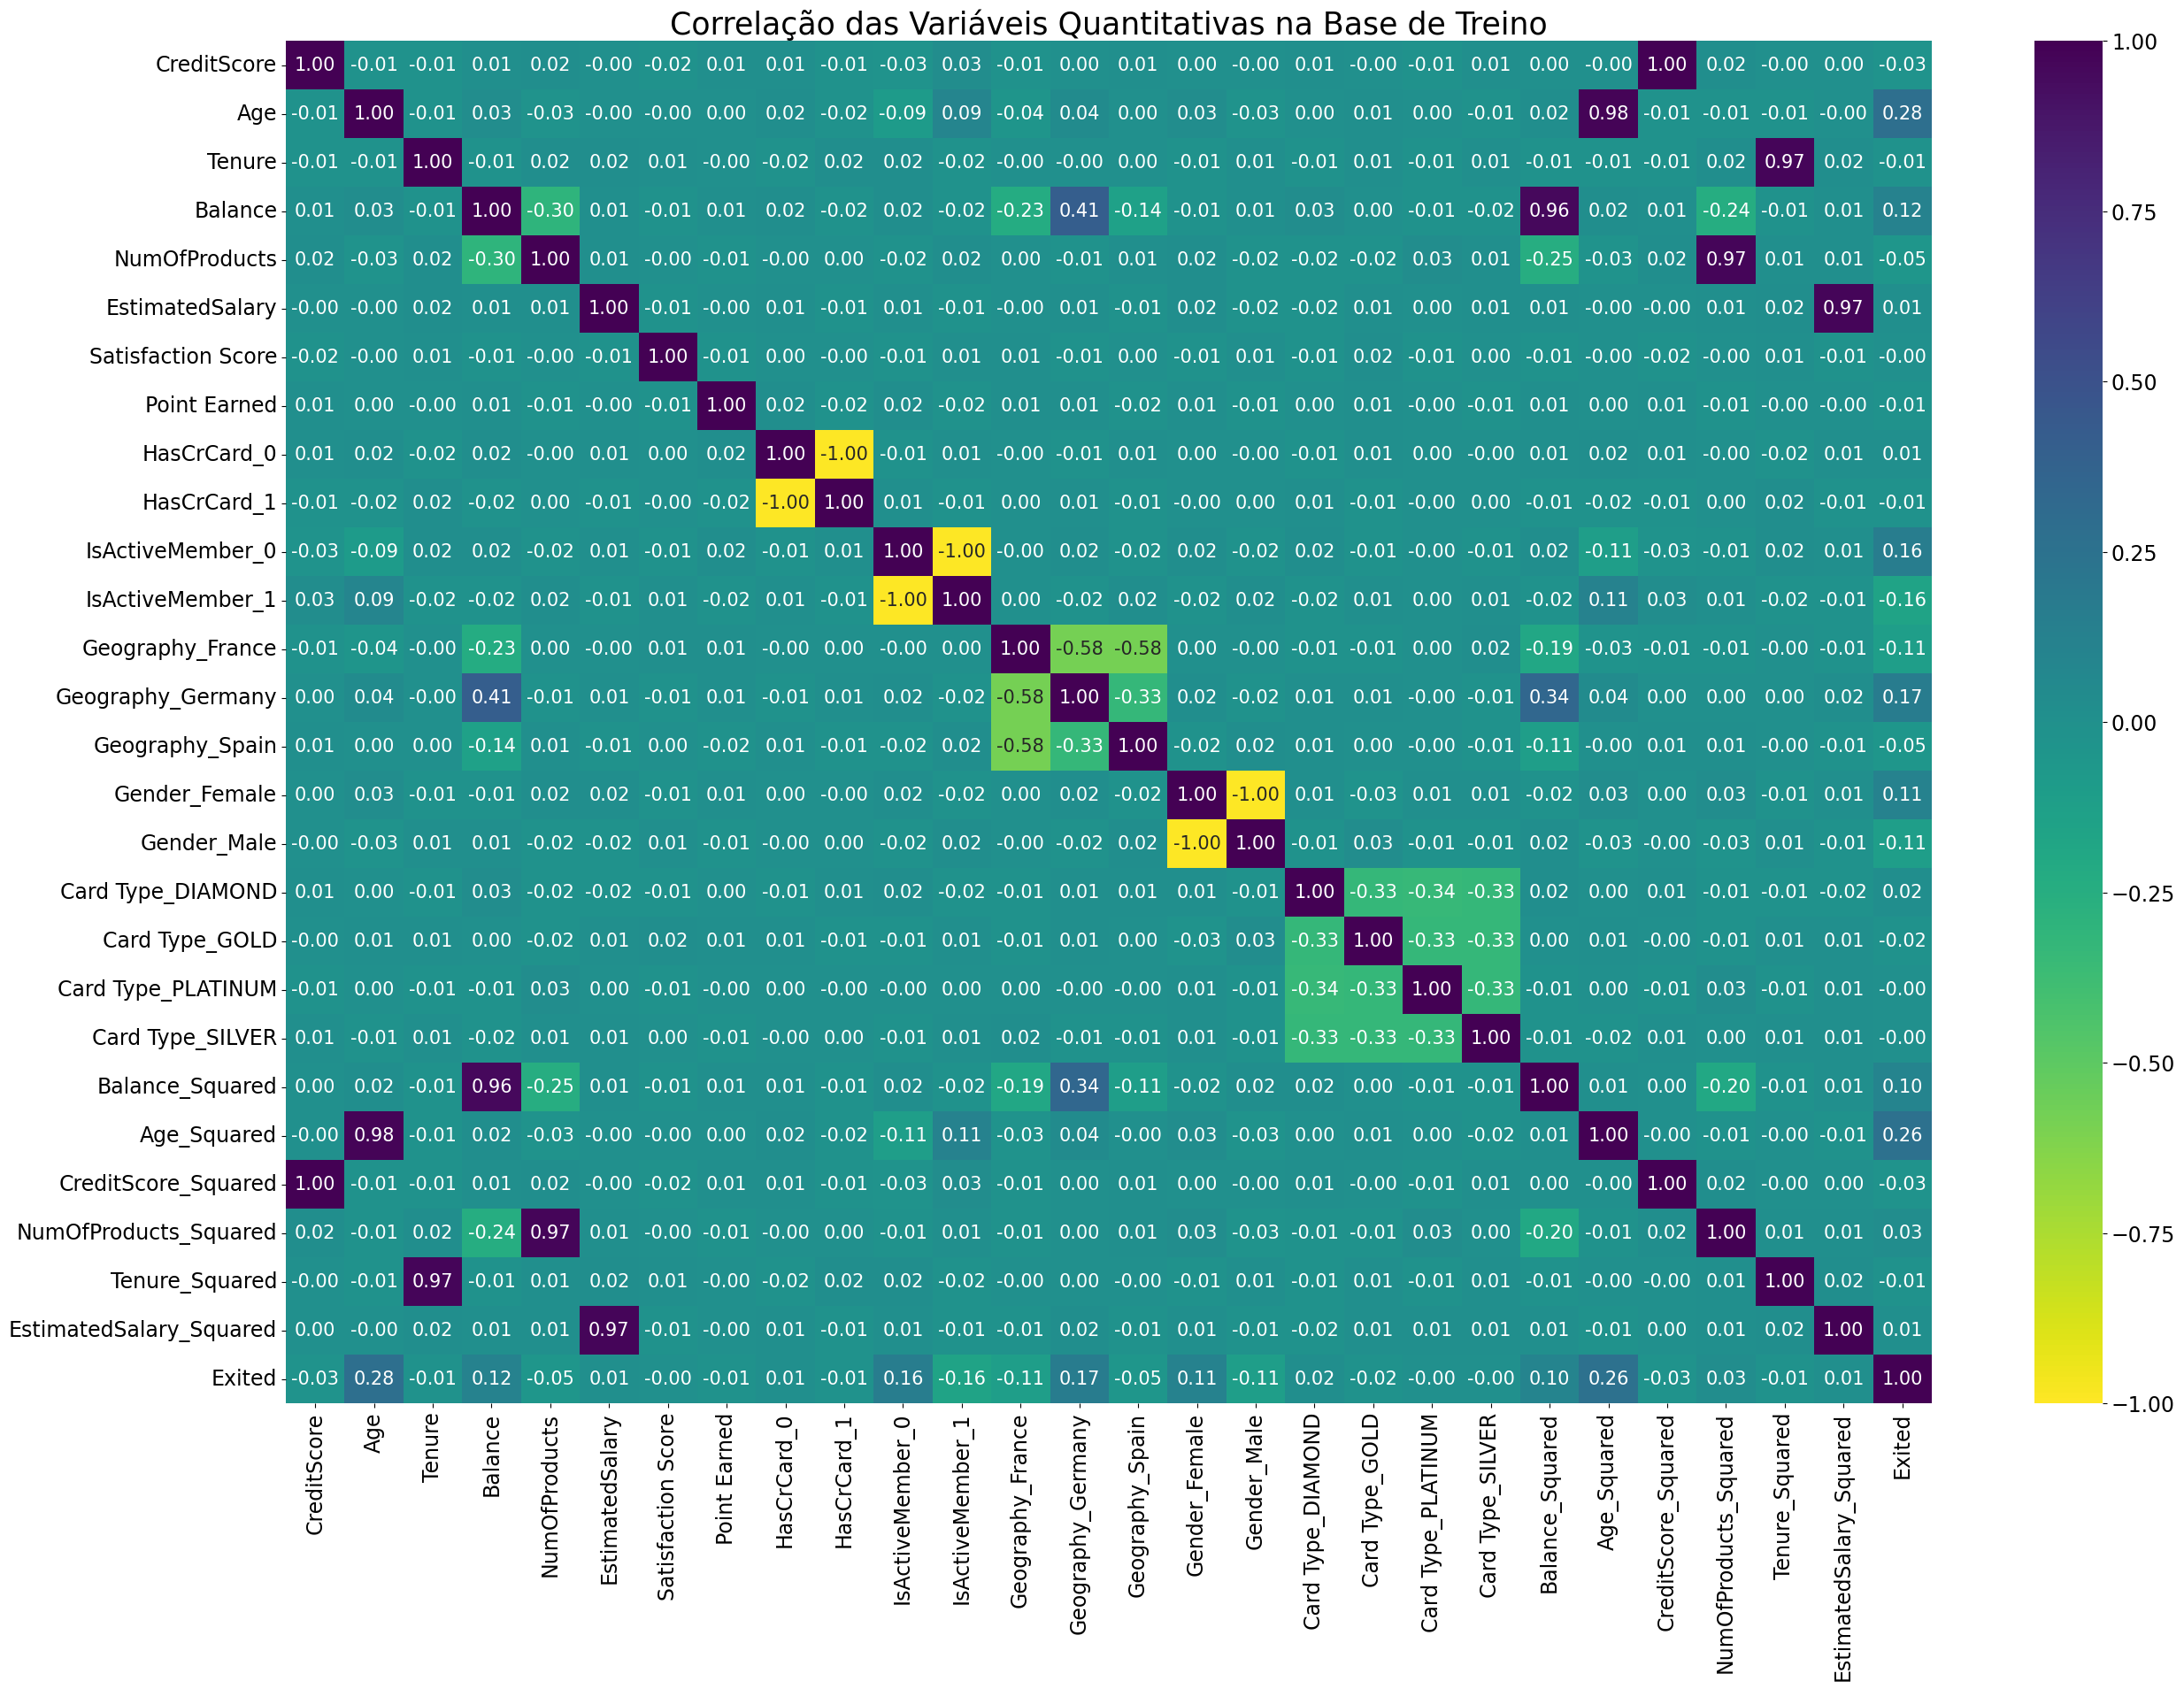

In [43]:
#Observando Multicolinearidade na base de treino

teste_multco_treino = pd.concat([X_train,y_train], axis = 1)

correlation_matrix_treino = teste_multco_treino.corr().round(2)
correlation_matrix_treino

# Matrix com  mapa de calor 
plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(correlation_matrix_treino, annot=True, fmt=".2f",
                      cmap=plt.cm.viridis_r, # paleta de cores viridis (ou viridis_r para o inverso de cores) é uma paleta especial 
                                             # para facilitar a visualizacao por pessoas com dificuldades visuais, como os daltonicos. 
                      annot_kws={'size': 15}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
plt.title('Correlação das Variáveis Quantitativas na Base de Treino',fontsize=25)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

# Analise e tratamento de Outliers 

* Outliers sao numericos e podem afetar de diversas formas modelos de MLP porque eles utilizam backpropagation e descida do gradiente, entre outras coisas que podem atrapalhar a capacidade preditiva do modelo; 

* para resolver sem perder dados, pois temos poucas observcoes para estudo, nao foram removidos como facilmente poderia fazer-se, ao inves foi aplicado winsorization; 

* winsorization e uma tecnica de limitacao dos outliers, ela substiui os valores de outlierns pelos limites superiores e inferiores; 

* Para isso, e calculado um intervalo de valores aceitos com base no primeiro quartil (Q1) e no terceiro quartil (Q3), valores abaixo do limite inferior ou acima do limite superior sao ajustados para os respectivos limites, corrigindo assim os outliers 

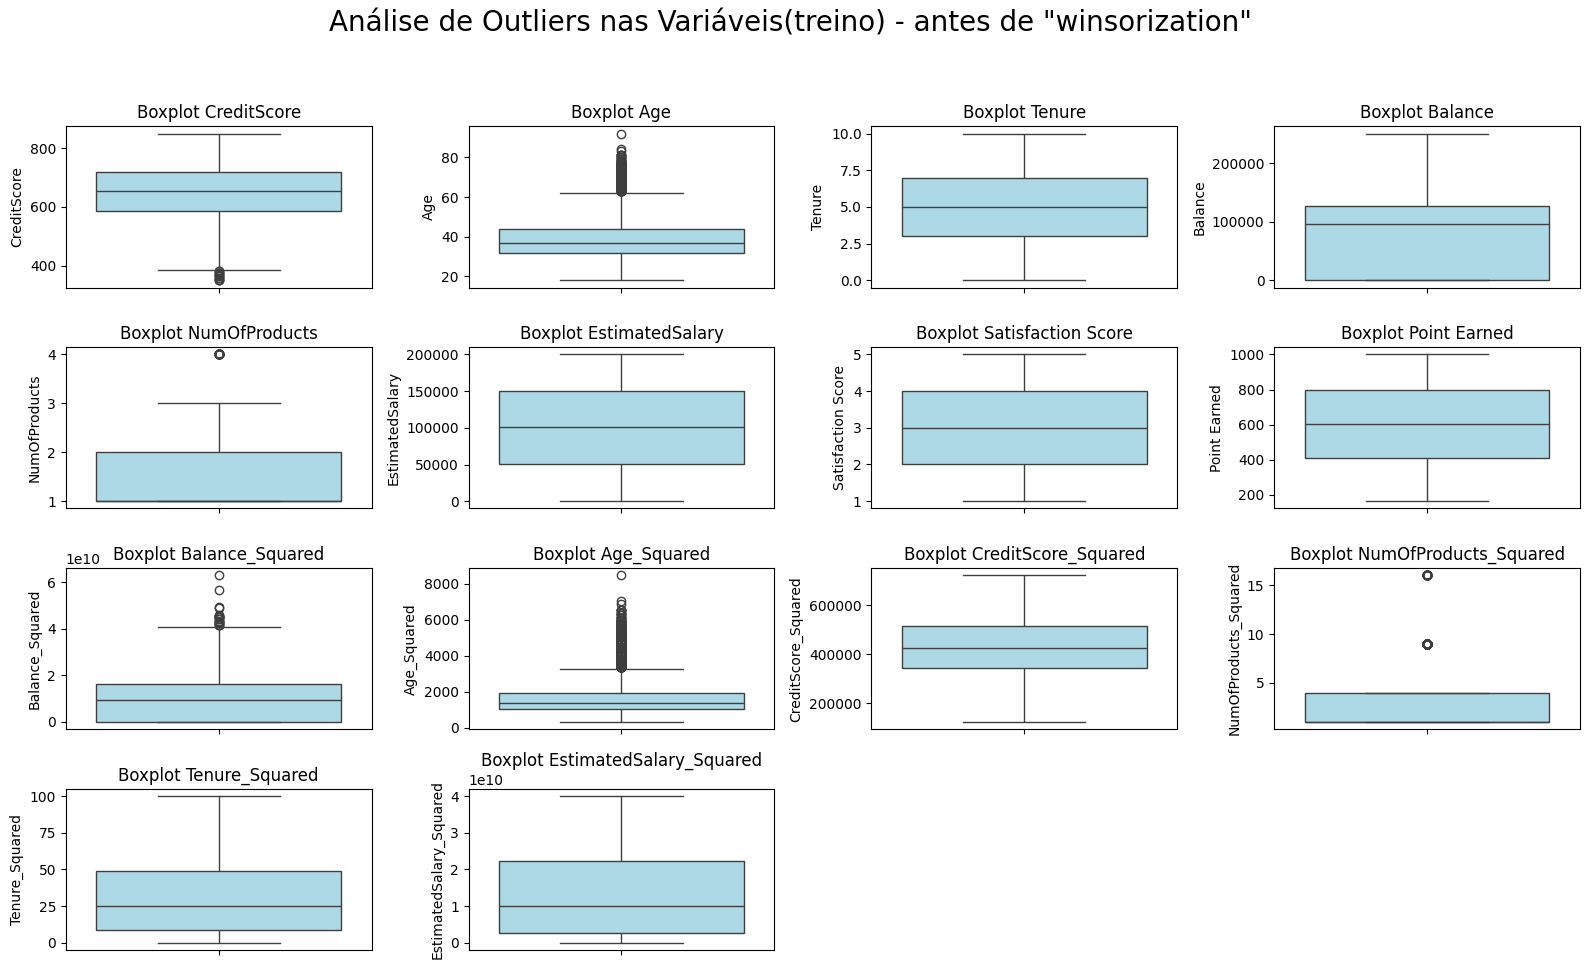

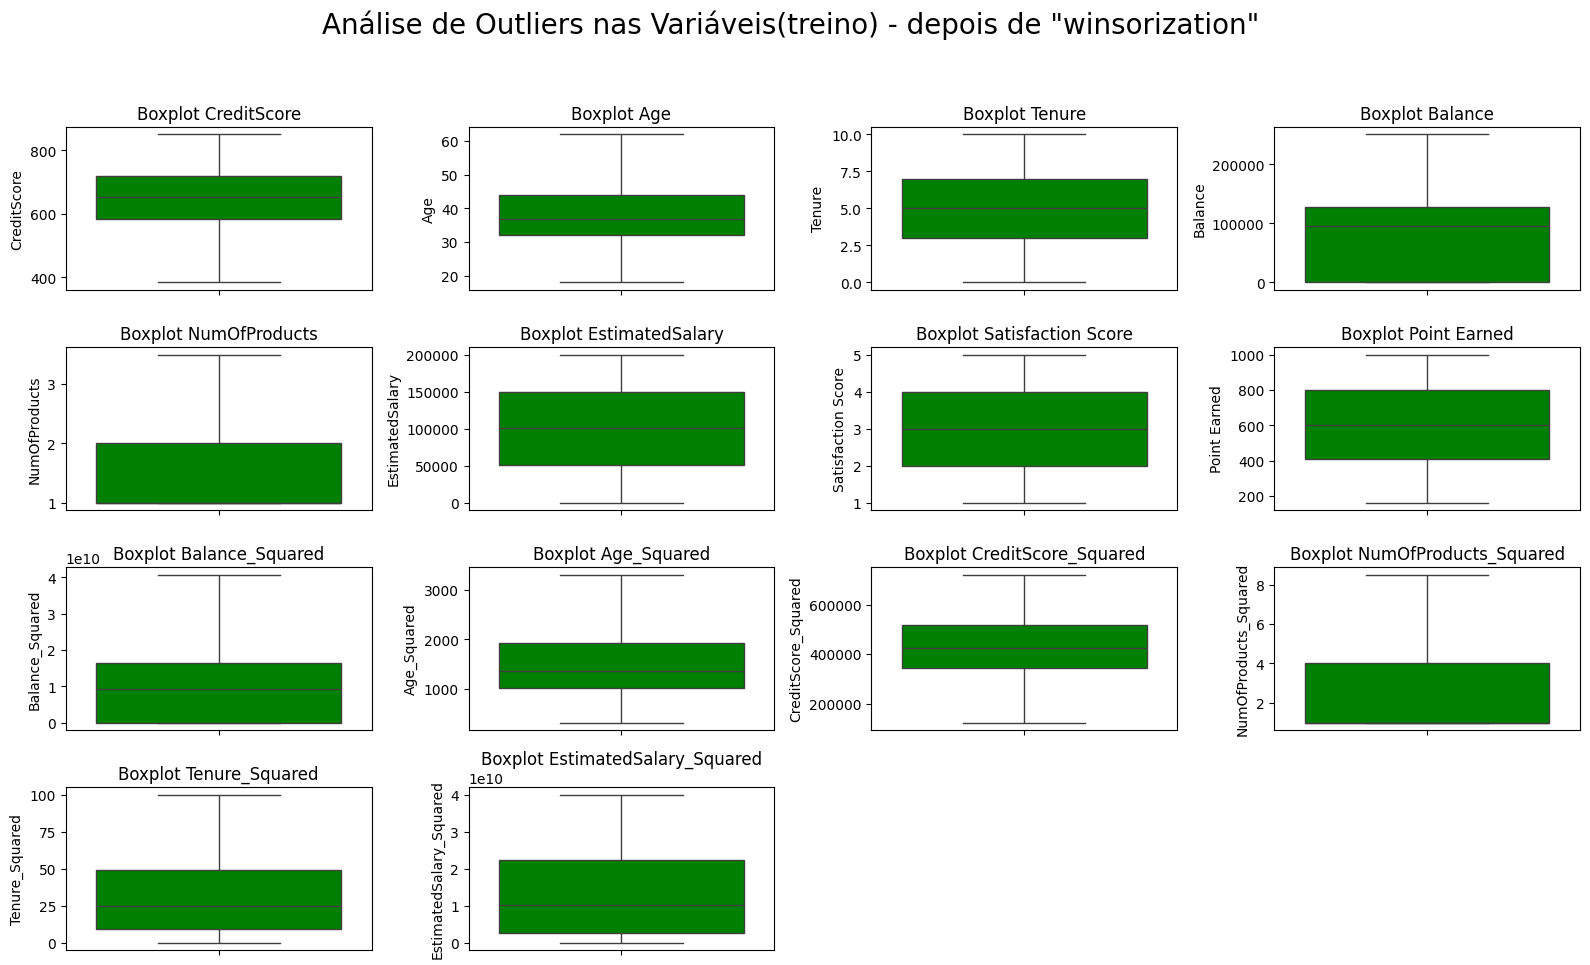

In [44]:
#%% analise de outliers das variaveis na base de treino 


###############antes de tratamento############################# 
variaveis = [
    'CreditScore',
    'Age',
    'Tenure',
    'Balance',
    'NumOfProducts',
    'EstimatedSalary',
    'Satisfaction Score',
    'Point Earned',
    #QUADRATICAS
    'Balance_Squared',
    'Age_Squared',
    'CreditScore_Squared',
    'NumOfProducts_Squared',
    'Tenure_Squared',
    'EstimatedSalary_Squared'
]


# definindo tamnhos de subplots 
plt.figure(figsize=(16, 12))

# loop de criacao de boxplots para cada variavel 
for i, var in enumerate(variaveis):
    plt.subplot(5, 4, i + 1)  #determina a grade de plots 
    sns.boxplot(y=teste_multco_treino[var],
               boxprops=dict(facecolor='lightblue'))  # Cor interna do boxplot 
    plt.title(f'Boxplot {var}', fontsize=12)
    
#  título geral
plt.suptitle('Análise de Outliers nas Variáveis(treino) - antes de "winsorization" ', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajuste de layout
plt.show()
###############################################################






# Função que aplica winsorization
def tratar_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    # Substitui outliers pelo limite inferior ou superior
    df[coluna] = np.where(df[coluna] < limite_inferior, limite_inferior, df[coluna])
    df[coluna] = np.where(df[coluna] > limite_superior, limite_superior, df[coluna])





###############depois de tratamento############################# 

# Aplicando a função nas variáveis 
variaveis_para_tratar = ['CreditScore',
                        'Age',
                        'Tenure',
                        'Balance',
                        'NumOfProducts',
                        'EstimatedSalary',
                        'Satisfaction Score',
                        'Point Earned',
                        #QUADRATICAS
                        'Balance_Squared',
                        'Age_Squared',
                        'CreditScore_Squared',
                        'NumOfProducts_Squared',
                        'Tenure_Squared',
                        'EstimatedSalary_Squared'
                         ]
for variavel in variaveis_para_tratar:
    tratar_outliers(teste_multco_treino, variavel)


# subplot
plt.figure(figsize=(16, 12))



# loop de criacao de boxplots para cada variavel 
for i, var in enumerate(variaveis):
    plt.subplot(5, 4, i + 1)  #determina a grade de plots 
    sns.boxplot(y=teste_multco_treino[var],
               boxprops=dict(facecolor='green'))  # Cor interna do boxplot
    plt.title(f'Boxplot {var}', fontsize=12)
########################################################################


# título geral
plt.suptitle('Análise de Outliers nas Variáveis(treino) - depois de "winsorization" ', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # ajusta layout
plt.show()

In [45]:
#BASE DE TREINO 
teste_multco_treino

CreditScore   Age  Tenure    Balance  NumOfProducts  EstimatedSalary  Satisfaction Score  Point Earned  HasCrCard_0  HasCrCard_1  IsActiveMember_0  IsActiveMember_1  Geography_France  Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  Card Type_DIAMOND  Card Type_GOLD  Card Type_PLATINUM  Card Type_SILVER  Balance_Squared  Age_Squared  CreditScore_Squared  NumOfProducts_Squared  Tenure_Squared  EstimatedSalary_Squared  Exited
9254        686.0  32.0     6.0       0.00            2.0        179093.26                 2.0         510.0            0            1                 0                 1                 1                  0                0              0            1                  1               0                   0                 0     0.000000e+00       1024.0             470596.0                    4.0            36.0             3.207440e+10       0
1561        632.0  42.0     4.0  119624.60            2.0        195978.86                 4.0         959.0            0            1                 0                 1                 0                  1                0              0            1                  0               0                   1                 0     1.431004e+10       1764.0             399424.0                    4.0            16.0             3.840771e+10       0
1670        559.0  24.0     3.0  114739.92            1.0         85891.02                 4.0         327.0            0            1                 1                 0                 0                  0                1              0            1                  0               0                   0                 1     1.316525e+10        576.0             312481.0                    1.0             9.0             7.377267e+09       1
6087        561.0  27.0     9.0  135637.00            1.0        153080.40                 2.0         567.0            0            1                 1                 0                 1                  0                0              1            0                  0               0                   0                 1     1.839740e+10        729.0             314721.0                    1.0            81.0             2.343361e+10       1
6669        517.0  56.0     9.0  142147.32            1.0         39488.04                 3.0         727.0            1            0                 1                 0                 1                  0                0              0            1                  0               0                   1                 0     2.020586e+10       3136.0             267289.0                    1.0            81.0             1.559305e+09       1
...           ...   ...     ...        ...            ...              ...                 ...           ...          ...          ...               ...               ...               ...                ...              ...            ...          ...                ...             ...                 ...               ...              ...          ...                  ...                    ...             ...                      ...     ...
5734        768.0  54.0     8.0   69712.74            1.0         69381.05                 3.0         569.0            0            1                 0                 1                 1                  0                0              0            1                  0               0                   0                 1     4.859866e+09       2916.0             589824.0                    1.0            64.0             4.813730e+09       0
5191        682.0  58.0     1.0       0.00            1.0           706.50                 4.0         709.0            0            1                 0                 1                 1                  0                0              1            0                  0               0                   1                 0     0.000000e+00       3304.0             465124.0                    1.0             1.

In [46]:
# BASE DE TESTE
base_corrige_teste = pd.concat([X_test,y_test], axis = 1)
base_corrige_teste


CreditScore  Age  Tenure    Balance  NumOfProducts  EstimatedSalary  Satisfaction Score  Point Earned  HasCrCard_0  HasCrCard_1  IsActiveMember_0  IsActiveMember_1  Geography_France  Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  Card Type_DIAMOND  Card Type_GOLD  Card Type_PLATINUM  Card Type_SILVER  Balance_Squared  Age_Squared  CreditScore_Squared  NumOfProducts_Squared  Tenure_Squared  EstimatedSalary_Squared  Exited
6252          596   32       3   96709.07              2         41788.37                   1           709            1            0                 1                 0                 0                  1                0              0            1                  0               1                   0                 0     9.352644e+09         1024               355216                      4               9             1.746268e+09       0
4684          623   43       1       0.00              2        146379.30                   2           508            0            1                 0                 1                 1                  0                0              0            1                  0               0                   0                 1     0.000000e+00         1849               388129                      4               1             2.142690e+10       0
1731          601   44       4       0.00              2         58561.31                   1           281            0            1                 1                 0                 0                  0                1              1            0                  0               1                   0                 0     0.000000e+00         1936               361201                      4              16             3.429427e+09       0
4742          506   59       8  119152.10              2        170679.74                   2           979            0            1                 0                 1                 0                  1                0              0            1                  0               0                   0                 1     1.419722e+10         3481               256036                      4              64             2.913157e+10       0
4521          560   27       7  124995.98              1        114669.79                   5           457            0            1                 0                 1                 0                  0                1              1            0                  0               0                   0                 1     1.562400e+10          729               313600                      1              49             1.314916e+10       0
...           ...  ...     ...        ...            ...              ...                 ...           ...          ...          ...               ...               ...               ...                ...              ...            ...          ...                ...             ...                 ...               ...              ...          ...                  ...                    ...             ...                      ...     ...
6412          602   53       5   98268.84              1         45038.29                   5           813            1            0                 0                 1                 0                  1                0              1            0                  0               0                   1                 0     9.656765e+09         2809               362404                      1              25             2.028448e+09       1
8285          609   25      10       0.00              1        109895.16                   2           652            1            0                 0                 1                 1                  0                0              0            1                  0               0                   1                 0     0.000000e+00          625               370881                      1             100        

# Preparacao dos dados  


* Preparacao dos dados 


------------------------
 DATA Prep
------------------------
------------------------
Início: 2025-02-26 00:49:07.129877
------------------------
Índices de X_test e y_test já estavam alinhados.


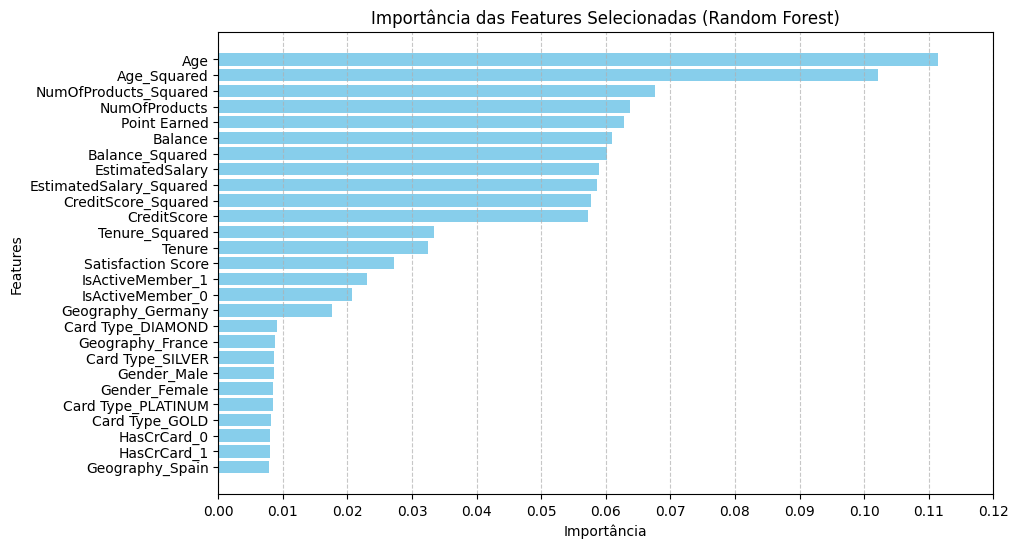

In [47]:
print('------------------------')
print(" DATA Prep")
print('------------------------')

# Desativando os warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
warnings.filterwarnings("ignore", category=UserWarning, module='optuna')
warnings.filterwarnings("ignore", category=FutureWarning, module='optuna')
warnings.filterwarnings('ignore', category=DeprecationWarning)
logging.getLogger("optuna").setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore", category=UserWarning, module='catboost')
warnings.filterwarnings("ignore", category=FutureWarning, module='catboost')
warnings.filterwarnings("ignore", category=UserWarning, message="Default metric period is 5 because AUC is/are not implemented for GPU")
#esse aviso reclama por causa do padrao de 'metric_period' ser 5 e isso nao ser compativel com o calculo de AUC (Default metric period is 5 because AUC is/are not implemented for GPU
optuna.logging.set_verbosity(optuna.logging.CRITICAL)




# início
start_time_utc = datetime.utcnow() - timedelta(hours=3)
print('------------------------')
print("Início:", start_time_utc)
print('------------------------')


######################################## PRE-PROCESSAMENTO E PREPARACAO NOS DADOS ################################################################### 



# Defini variáveis de treinamento
X_train = teste_multco_treino.drop('Exited', axis=1)
y_train = teste_multco_treino['Exited']

# Verifica e conserta desalinhamento de índices caso tenha (X_test e y_test)
if not X_test.index.equals(y_test.index):
    print("Índices de X_test e y_test não estavam alinhados. Realinhando y_test.")
    y_test = y_test.loc[X_test.index]
else:
    print("Índices de X_test e y_test já estavam alinhados.")

# Concatena os dados corrigidos para criar a base de teste
base_corrige_teste = pd.concat([X_test, y_test], axis=1)

# Redefini X_test e y_test com índices corrigidos e verificados
X_test = base_corrige_teste.drop('Exited', axis=1)
y_test = base_corrige_teste['Exited']




# Criar e treinar o modelo Random Forest para selecionar as melhores variaveis 
#detalhe importante, nao tem predict(), somente o fit() 
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# Obter a importância das features
feature_importances = rf.feature_importances_

# Criar DataFrame com os nomes das features e suas importâncias
feature_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Filtrar features com importância maior que 0.01 (ou outro threshold desejado)
selected_features = feature_df[feature_df['Importance'] > 0.01]['Feature'].tolist()

# Ordenar as features pela importância (do menor para o maior)
feature_df = feature_df.sort_values(by='Importance', ascending=True)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Importância das Features Selecionadas (Random Forest)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, max(feature_df['Importance'])+0.01, 0.01))


# Mostrar o gráfico
plt.show()




# Finalizando preparacao e selecionando variaveis

Variaveis selecionadas conforme o modelo classificador de importancia usado anteriormente (randomforest) 

In [48]:

print("Shape X_train antes de selecionar as fetuares importantes:", X_train.shape)
print("Shape y_train antes de selecionar as fetuares importantes:", y_train.shape)

start_time_utc = datetime.utcnow() - timedelta(hours=3)
print("Tempo de Início:", start_time_utc)
print('------------------------')


X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train, y_train = X_train_selected , y_train
X_test, y_test = X_test_selected , y_test

print("Shape X_train (selecionadas):", X_train.shape)
print("Shape y_train (selecionadas):", y_train.shape)

print("Shape X_test (selecionadas):", X_test.shape)
print("Shape y_test (selecionadas):", y_test.shape)


#verificando alinhamneto
assert X_train.shape[0] == y_train.shape[0], "Erro: Número de amostras não coincide"
assert X_test.shape[0] == y_test.shape[0], "Erro: Número de amostras não coincide"


Shape X_train antes de selecionar as fetuares importantes: (8000, 27)
Shape y_train antes de selecionar as fetuares importantes: (8000,)
Tempo de Início: 2025-02-26 00:49:10.978928
------------------------
Shape X_train (selecionadas): (8000, 17)
Shape y_train (selecionadas): (8000,)
Shape X_test (selecionadas): (2000, 17)
Shape y_test (selecionadas): (2000,)


# Modelagem: Catboost e Optuna 
**estudo de otimizacao de hiperparametros com Optuna e modelagem**

In [49]:

# Configurações
print("##############  Modelagem  ##########################")

print('------------------------')
print("CatBoost")
print('------------------------')



# Verifica se há GPU disponível
use_gpu = torch.cuda.is_available()
device = "cuda" if use_gpu else "cpu"
print(f"Usando GPU: {use_gpu}")

# Sampler para Optuna
sampler = optuna.samplers.TPESampler(n_startup_trials=10, n_ei_candidates=10, seed=42)

# Variáveis globais
n_trials = 30
n_splits_ = 5
epochs = 100
weights = {
    'f1': 0.20,
    'precision': 0.20,
    'recall': 0.40,
    'auc': 0.10,
    'balanced_acc': 0.05,
    'mcc': 0.05
}

limiar = 0.5  # ou threshold 

# Criando uma barra de progresso
progress_bar = tqdm(total=n_trials, desc="Otimização em andamento", unit="trial")


# StandardScaler (normalização)
def apply_scaling(X_train, X_valid):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    return X_train_scaled, X_valid_scaled

# Função para treinar o modelo CatBoost
def train_catboost(param, X_train, y_train, X_valid, y_valid):
    train_pool = Pool(X_train, label=y_train)
    valid_pool = Pool(X_valid, label=y_valid)
    
    model = CatBoostClassifier(
        iterations=param['iterations'],
        learning_rate=param['learning_rate'],
        depth=param['depth'],
        l2_leaf_reg=param['l2_leaf_reg'],
        border_count=param['border_count'],
        loss_function=param['loss_function'],  # A função de perda será atribuída diretamente do param
        eval_metric=param['eval_metric'],  # A métrica de avaliação será atribuída diretamente do param
        task_type='GPU' if use_gpu else 'CPU',  # Usará GPU ou CPU conforme configuração
        logging_level='Silent',  # Supressão dos logs do CatBoost
        scale_pos_weight=param['scale_pos_weight'],  # Ajuste de scale_pos_weight a partir do param
        bagging_temperature=param['bagging_temperature'],  # Temperatura de bagging conforme param
        min_data_in_leaf=param['min_data_in_leaf'],  # Mínimo de dados por folha conforme param
        
)

    
    

    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=param['early_stopping_rounds'])
    
    # Calcular AUC após o treinamento
    y_pred = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_pred)
    
    return y_pred, auc
    
    

# Definição da função de otimização para o Optuna
def objective(trial):
    global progress_bar

    param = {
    'iterations': trial.suggest_int('iterations', 300, 600),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
    'depth': trial.suggest_int('depth', 6, 12),
    'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 5.0),
    'border_count': trial.suggest_int('border_count', 32, 255),
    'loss_function': 'Logloss',
    'eval_metric': 'F1',
    'task_type': 'GPU' if use_gpu else 'CPU',
    'logging_level': 'Silent',
    'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight', 1, 10),
    'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.2, 1.0),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
    'max_bin': trial.suggest_int('max_bin', 32, 255),
    'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50)  # Adicionando este parâmetro
    }




    # Inicialização do Cross-Validation
    skf = StratifiedKFold(n_splits=n_splits_, shuffle=True, random_state=42)
    weighted_scores = []
    global limiar  # Acessa a variável limiar global

    for train_idx, valid_idx in skf.split(X, y):
        # Divisão do dataset em treino e validação
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # Aplicar o StandardScaler no conjunto de treino e validação
        X_train_scaled, X_valid_scaled = apply_scaling(X_train, X_valid)

        # Treinamento do modelo e obtenção das previsões
        y_pred, auc = train_catboost(param, X_train_scaled, y_train, X_valid_scaled, y_valid)

        # Converte probabilidades em classes binárias (0 ou 1) usando threshold de 0.5
        y_pred_class = (y_pred > limiar ).astype(int)

        # Cálculo das métricas
        f1 = f1_score(y_valid, y_pred_class)
        precision = precision_score(y_valid, y_pred_class)
        recall = recall_score(y_valid, y_pred_class)
        balanced_acc = balanced_accuracy_score(y_valid, y_pred_class)
        mcc = matthews_corrcoef(y_valid, y_pred_class)

        # Cálculo da métrica ponderada
        weighted_score = (
            weights['f1'] * f1 + 
            weights['precision'] * precision +  
            weights['recall'] * recall +  
            weights['auc'] * auc + 
            weights['balanced_acc'] * balanced_acc + 
            weights['mcc'] * mcc
        )

        weighted_scores.append(weighted_score)

    # Retorno da média da métrica ponderada para otimização
    progress_bar.update(1)
    return np.mean(weighted_scores)


# Otimização com Optuna
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=n_trials)

best_params = study.best_params

# Melhores hiperparâmetros
print("📊 MELHORES HIPERPARÂMETROS ENCONTRADOS")
print("═" * 60)
print(f"{'Hiperparâmetro':<25}{'Valor':<15}")
print("─" * 60)
for param, value in best_params.items():
    value = value if value is not None else "N/A"  
    print(f"{param:<25}{value:<15}")
print("═" * 60)

print("✅ Otimização concluída!")
progress_bar.close()


##############  Modelagem  ##########################
------------------------
CatBoost
------------------------
Usando GPU: True


Otimização em andamento: 100%|██████████| 30/30 [12:40<00:00, 25.36s/trial]

📊 MELHORES HIPERPARÂMETROS ENCONTRADOS
════════════════════════════════════════════════════════════
Hiperparâmetro           Valor          
────────────────────────────────────────────────────────────
iterations               599            
learning_rate            0.05061526440977015
depth                    8              
l2_leaf_reg              2.66786074291965
border_count             38             
scale_pos_weight         4.7380005446514835
bagging_temperature      0.873455389283781
min_data_in_leaf         1              
max_bin                  101            
early_stopping_rounds    45             
════════════════════════════════════════════════════════════
✅ Otimização concluída!


# Treinamento Final 
**Usando resultados adquiridos no estudo do Optuna**

########### Treinamento Final ###########: 100%|██████████████████| 100/100 [06:44<00:00,  4.05s/it]


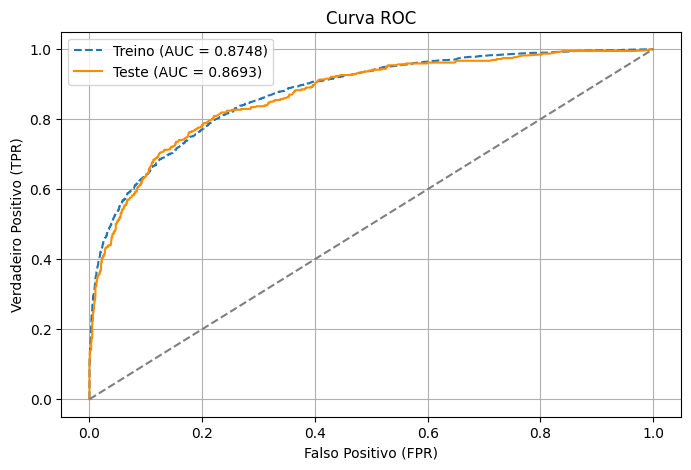

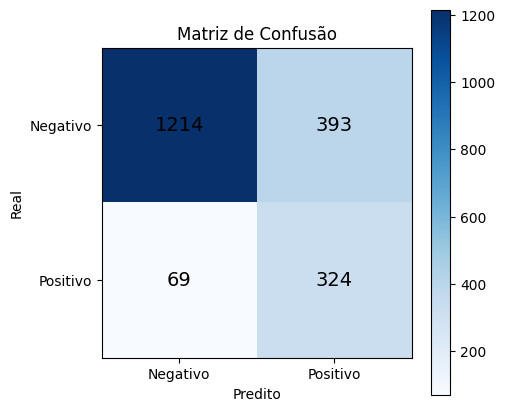


📊 MÉTRICAS DO MODELO - TREINAMENTO FINAL
Métrica             Treino         Teste          
------------------------------------------------------------
Acurácia            0.7709         0.7690         
Precisão            0.4672         0.4519         
Recall              0.8140         0.8244         
F1-Score            0.5937         0.5838         
AUC-ROC             0.8748         0.8693         
MCC                 0.4836         0.4805         
Kappa de Cohen      0.4499         0.4422         
Acurácia Balanceada 0.7868         0.7899         


In [ ]:

# Barra de progresso
bar = tqdm(total=epochs, desc="########### Treinamento Final ###########", ncols=100, position=0)

# Aplicar o scaler nos dados de treino e teste
X_train_scaled, X_test_scaled = apply_scaling(X_train, X_test)

# Criar pools de dados para o CatBoost
train_pool = Pool(X_train_scaled, label=y_train)
test_pool = Pool(X_test_scaled, label=y_test)

# Configurar o modelo CatBoost
catboost_model = CatBoostClassifier(
    iterations=best_params['iterations'],
    learning_rate=best_params['learning_rate'],
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    border_count=best_params['border_count'],
    loss_function='Logloss',  # A função de perda será atribuída diretamente do param
    eval_metric='F1',  # A métrica de avaliação será atribuída diretamente do param
    task_type='GPU' if use_gpu else 'CPU',  # Usará GPU ou CPU conforme configuração
    logging_level='Silent',  # Supressão dos logs do CatBoost
    scale_pos_weight=best_params['scale_pos_weight'],  # Ajuste de scale_pos_weight a partir do param
    bagging_temperature=best_params['bagging_temperature'],  # Temperatura de bagging conforme param
    min_data_in_leaf=best_params['min_data_in_leaf'],  # Mínimo de dados por folha conforme param
    )

# Treinamento incremental
for epoch in range(epochs):
    catboost_model.fit(
        train_pool,
        eval_set=test_pool,
        early_stopping_rounds=best_params['early_stopping_rounds'],
        verbose_eval=False
    )
    bar.update(1)  # Atualiza a barra 

# Fecha a barra 
bar.close()

# Salvar o modelo
with open("catboost_model.pkl", "wb") as f:
    pickle.dump(catboost_model, f)

# Predições
y_train_pred_proba = catboost_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = catboost_model.predict_proba(X_test_scaled)[:, 1]
y_train_pred = (y_train_pred_proba > limiar).astype(int)
y_test_pred = (y_test_pred_proba > limiar).astype(int)

# Métricas
metrics = {
    "Acurácia": accuracy_score,
    "Precisão": precision_score,
    "Recall": recall_score,
    "F1-Score": f1_score,
    "AUC-ROC": roc_auc_score,
    "MCC": matthews_corrcoef,
    "Kappa de Cohen": cohen_kappa_score,
    "Acurácia Balanceada": balanced_accuracy_score
}

# Gráfico de Curva ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

auc_train = roc_auc_score(y_train, y_train_pred_proba)
auc_test = roc_auc_score(y_test, y_test_pred_proba)

plt.figure(figsize=(8, 5))
plt.plot(fpr_train, tpr_train, label=f"Treino (AUC = {auc_train:.4f})", linestyle="--")
plt.plot(fpr_test, tpr_test, label=f"Teste (AUC = {auc_test:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.title("Curva ROC")
plt.legend()
plt.grid()
plt.show()

# Gráfico de Matriz de Confusão
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5, 5))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.colorbar()
plt.xticks([0, 1], ["Negativo", "Positivo"])
plt.yticks([0, 1], ["Negativo", "Positivo"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=14)
plt.show()

# Exibir métricas
print("\n📊 MÉTRICAS DO MODELO - TREINAMENTO FINAL")
print("=" * 60)
print(f"{'Métrica':<20}{'Treino':<15}{'Teste':<15}")
print("-" * 60)
for metric_name, metric_func in metrics.items():
    train_score = metric_func(y_train, y_train_pred_proba if metric_name == "AUC-ROC" else y_train_pred)
    test_score = metric_func(y_test, y_test_pred_proba if metric_name == "AUC-ROC" else y_test_pred)
    print(f"{metric_name:<20}{train_score:<15.4f}{test_score:<15.4f}")
print("=" * 60)




# Aplicacao final 
**aplicando em dados que simulam dados novos de producao** 

**OBS** Como nao ha dados novos para testar, foi utilizada a base inteira (features selecionadas com base no estudo de melhorar variavies feito com randomforest)


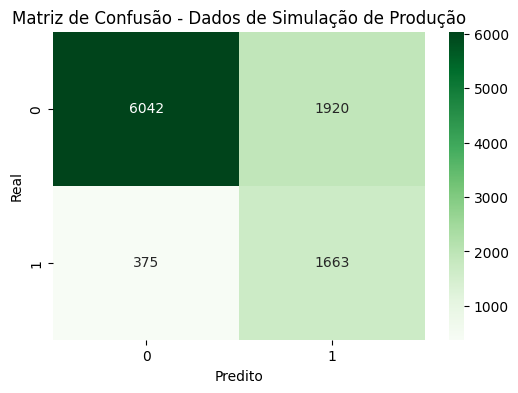

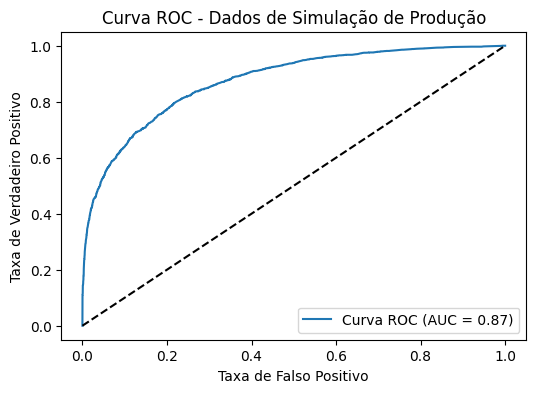

📊 MÉTRICAS DO MODELO - SIMULA PRODUCAO
Métrica             Valor final    
------------------------------------------------------------
Acurácia            0.7705
Precisão            0.4641
Recall              0.8160
F1-Score            0.5917
AUC-ROC             0.8737
MCC                 0.4829
Kappa de Cohen      0.4484
Acurácia Balanceada 0.7874


In [ ]:


# Carrega o modelo CatBoost
with open("catboost_model.pkl", "rb") as f:
    catboost_model = pickle.load(f)

# Carrega o scaler
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Carrega dados
df_new = pd.concat([base_corrige_teste, teste_multco_treino], axis=0)

# Seleciona as features (feito com randomforest)
X_new = df_new[selected_features]

# Separar as valores reais de y
y_true = df_new['Exited'].values  

# Normaliza 
X_scaled = scaler.transform(X_new)

# Obtem predições 
predictions = catboost_model.predict_proba(X_scaled)[:, 1]

# Converte probabilidades em classes com base no limiar definido (variaveis globais)
y_pred_class = (predictions > limiar).astype(int)

# Calcula matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Dados de Simulação de Produção')
plt.show()

# Calcula Curva ROC e AUC
fpr, tpr, _ = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Linha de referência
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC - Dados de Simulação de Produção')
plt.legend()
plt.show()


#métricas de avaliação de classificação
metrics = {
    "Acurácia": accuracy_score,
    "Precisão": precision_score,
    "Recall": recall_score,
    "F1-Score": f1_score,
    "AUC-ROC": roc_auc_score,
    "MCC": matthews_corrcoef,
    "Kappa de Cohen": cohen_kappa_score,
    "Acurácia Balanceada": balanced_accuracy_score
}

metric_results = {}

for metric_name, metric_function in metrics.items():
    if metric_name == "AUC-ROC":
        score = metric_function(y_true, predictions)
    else:
        score = metric_function(y_true, y_pred_class)
    metric_results[metric_name] = score

# printa métricas 
print("📊 MÉTRICAS DO MODELO - SIMULA PRODUCAO")
print("="*60)
print(f"{'Métrica':<20}{'Valor final':<15}")
print("-"*60)

for metric_name, score in metric_results.items():
    print(f"{metric_name:<20}{score:.4f}")

print("="*60)






# Construcao  de Propensão a Churn 

* Alem de classificar como churn ou nao churn com base em um limiar de decisao, como feito anteriormente, tambem e possivel classificar cada observacao (ou clientes) em decis, 
com base em sua propabilidade de vir a ser churn. Dessa forma e possivel implementar acoes com base nesses decis. 

* Exemplo:  Time responsavel pela reducao de churn vai implementar uma acao mais agressiva (mais cara) nos clientes de maior probabilidade de churn, que sao os clientes entre os decis 10 e 7 
e nos demais, ou seja, de 6 a 1, uma abordagem mais cautelosa (mais barata). 



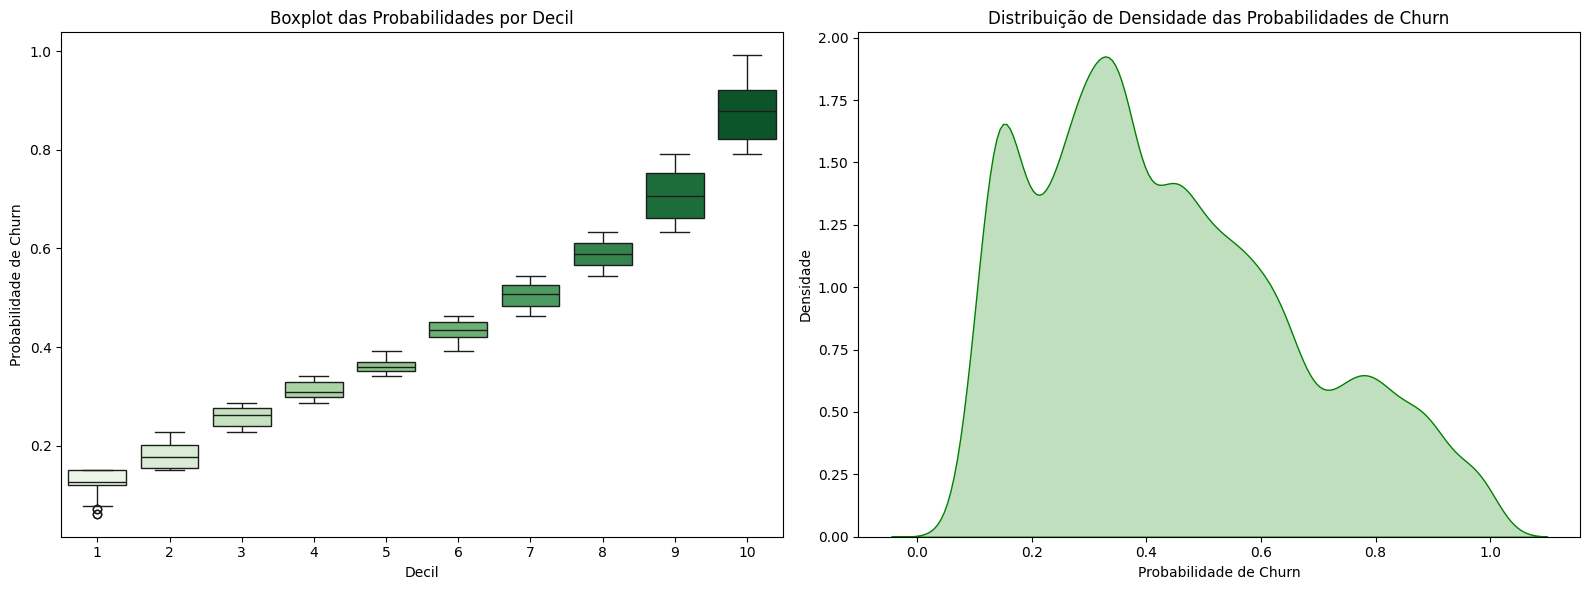

      RowNumber  CustomerId      Surname  CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  Complain  Satisfaction Score Card Type  Point Earned  probabilidade_churn decil_churn
1265       1266    15662291     Davidson          534    France  Female   55       8  116973.26              3          1               0        122066.50       1         1                   1  PLATINUM           840             0.991505          10
6279       6280    15608338    Chiemenam          757     Spain  Female   55       9  117294.12              4          1               0         94187.47       1         1                   2   DIAMOND           918             0.991505          10
1798       1799    15610446     Chinedum          714    France  Female   51       4   88308.87              3          0               0          5862.53       1         1                   3      GOLD           738             0.991257          10


In [ ]:

########CARREGA E APLICA MODELO GERANDO AS PROBABILIDADES##################################################
# Carrega o modelo CatBoost
with open("catboost_model.pkl", "rb") as f:
    catboost_model = pickle.load(f)

#  scaler
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# dados
df_new = pd.concat([base_corrige_teste, teste_multco_treino], axis=0)

# Seleciona as features 
X_new = df_new[selected_features]

# Normaliza 
X_scaled = scaler.transform(X_new)

# predições 
df_new["probabilidade_churn"] = catboost_model.predict_proba(X_scaled)[:, 1]




##########GERA OS DECIS COM BASE NAS PROBABILIDADES E CRIA VARIAVEL ######################################################

# Copia base original 
df_original_propenso = base_original.copy()

# cria variavel com as probabilidades no df 
df_original_propenso = df_original_propenso.merge(df_new[["probabilidade_churn"]], left_index=True, right_index=True, how="left")

# Ordena 
df_original_propenso = df_original_propenso.sort_values(by="probabilidade_churn", ascending=False)



# Adiciona um pequeno ruído aos valores duplicados 
# (TRATA VALORES DUPLICADOS PARA NAO TER ERROS NA CRIACAO DA VARIAVEL DECIL E PLOTAGEM, O RUIDO E MUITO BAIXO, LITERALEMNTE ALTERA VALORES MINIMAMENTE)
df_original_propenso["probabilidade_churn"] = df_original_propenso["probabilidade_churn"] + np.random.uniform(-1e-10, 1e-10, size=len(df_original_propenso))

# criando variavel decil
df_original_propenso["decil_churn"] = pd.qcut(df_original_propenso["probabilidade_churn"], q=10, labels=range(1, 11))



#plotando graficos

# Configurando o layout para subplots (1 linha, 2 colunas)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot
sns.boxplot(x=df_original_propenso["decil_churn"], y=df_original_propenso["probabilidade_churn"], palette="Greens", ax=axes[0])
axes[0].set_xlabel("Decil")
axes[0].set_ylabel("Probabilidade de Churn")
axes[0].set_title("Boxplot das Probabilidades por Decil")

# Gráfico de Densidade (KDE)
sns.kdeplot(df_original_propenso["probabilidade_churn"], fill=True, color="green", ax=axes[1])
axes[1].set_xlabel("Probabilidade de Churn")
axes[1].set_ylabel("Densidade")
axes[1].set_title("Distribuição de Densidade das Probabilidades de Churn")

# Exibir ambos os gráficos
plt.tight_layout()
plt.show()





#Salvando em excel da base inteira (output final).
df_original_propenso.to_excel("Propensao_churn_catb.xlsx", index=False)


print(df_original_propenso.head(10000))


In [53]:
# Fim do processo
end_time_utc = datetime.utcnow() - timedelta(hours=3)
print('============================================================')
print('******************Tempo de processamento********************')
print("Início:", start_time_utc)
print("Fim:   ", end_time_utc)
print('============================================================')
time_difference = (end_time_utc - start_time_utc).total_seconds() / 3600
print(f"Diferença: {time_difference:.2f} horas")
print('============================================================')


******************Tempo de processamento********************
Início: 2025-02-26 00:49:10.978928
Fim:    2025-02-26 01:08:40.028968
Diferença: 0.32 horas


# **Conclusão Treinamento e Predição** 

Hiperparametos ajustados; 

Treinamento final com boa generalizacao (diferenca entre auc's de treino e teste baixa, descartando Overfitting);

Teste final bem concluido, mas com espaço para melhoria em recall, métrica que de fato prediz o churn; 


* Acurácia (Accuracy): 77%
* Precisão (Precision): 46%
* Revocação (Recall): 81.6%
* Área sob a Curva (ROC AUC): 87%

# **Conclusão Propensão a Churn** 

* As observações foram classificadas com base em sua probabilidade de churn, e uma variável de decil foi criada. Dessa forma, é possível realizar ações personalizadas conforme o percentil de cada cliente.

* A variável foi incorporada ao dataset original e exportada, podendo servir de insumo para o time responsável tomar decisões de marketing, planejar tratamentos diferenciados e especiais, ou qualquer ação que envolva custos adicionais ou a implementação de múltiplas estratégias.

* É possivel observar uma alta concentracao das probabilidades entre 15% e 60%, se atenuando ate 90%. Mostra que há espaço para melhoria preditiva, o ideal era que a concenmtrcao ocorrece o mais proximo de 100%. No boxplot e possivel ver as probabilidades por decil e notar que a divisao ocorre bem, e o corpo do boxplot nos diz que ha valores razoaveis e nao discrepantes dentro de cada decil. 